In [1]:
# instalacja potrzebnych bibliotek
# !pip install openml
# !pip install scikit-learn
# !pip install scikit-optimize

### Motywacja wynikająca z literatury

https://arxiv.org/pdf/1710.04725.pdf

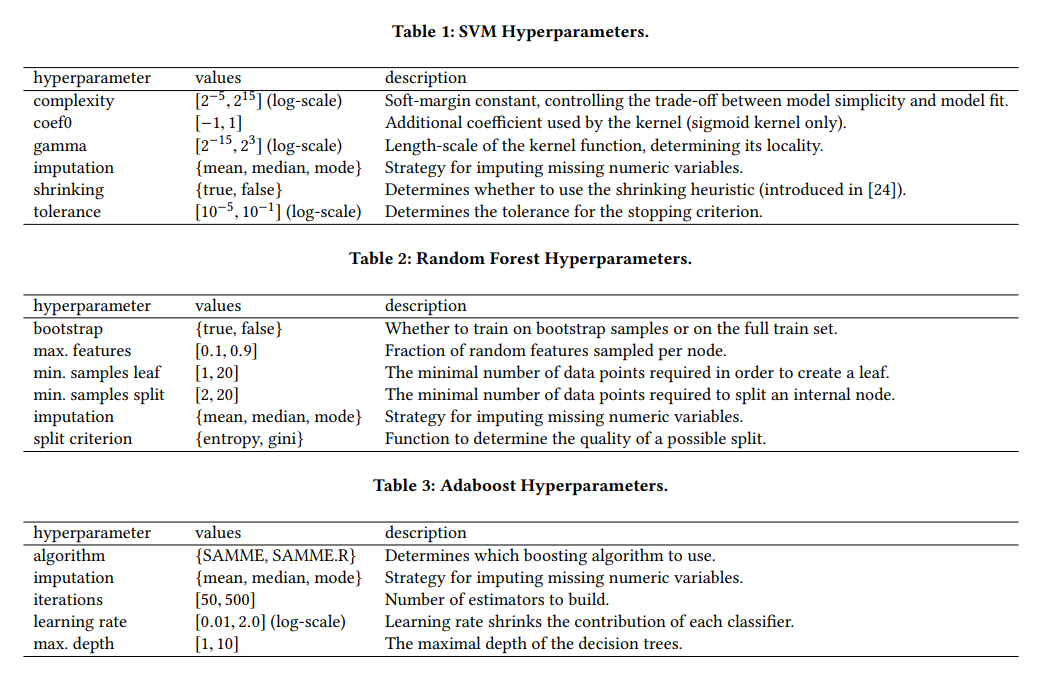

https://arxiv.org/pdf/2107.08761.pdf

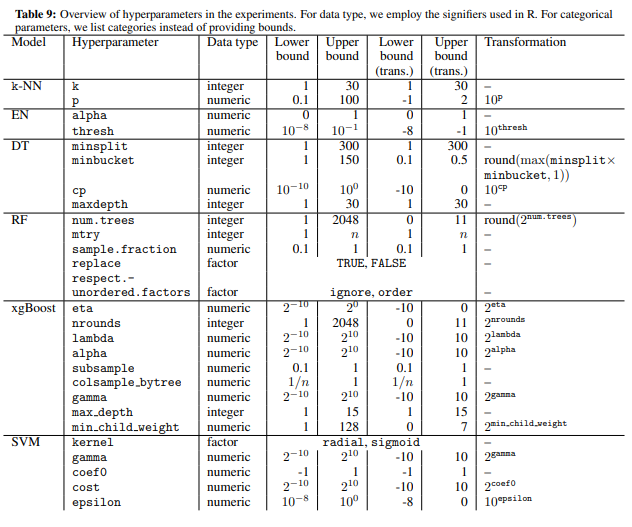

### Wczytanie bibliotek

In [2]:
import openml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score

# użyte modele
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

sns.set_theme(style="whitegrid", font_scale=1.2)

### Wczytanie danych

In [3]:
dataset = openml.datasets.get_dataset(1067)
X_1, y_1, _, _ = dataset.get_data(dataset_format="dataframe")
y_1 = X_1['defects']
X_1 = X_1.drop('defects', axis=1)
dataset = openml.datasets.get_dataset(4135)
X_2, y_2, _, _ = dataset.get_data(dataset_format="dataframe")
y_2 = X_2['target']
X_2 = X_2.drop('target', axis=1)
dataset = openml.datasets.get_dataset(1494)
X_3, y_3, _, _ = dataset.get_data(dataset_format="dataframe")
y_3 = X_3['Class']
X_3 = X_3.drop('Class', axis=1)
dataset = openml.datasets.get_dataset(40900)
X_4, y_4, _, _ = dataset.get_data(dataset_format="dataframe")
y_4 = X_4['Target']
X_4 = X_4.drop('Target', axis=1)

c:\ProgramData\Anaconda3\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\openml\datasets\functions.py:438: FutureWarni

### Potrzebne funkcje

In [4]:
n_iter = 100
random_state = 0

def score(estimator, params, X, y):
    estimator.set_params(**params)
    return np.mean(cross_val_score(estimator, X, y, cv=5, n_jobs=-1, scoring="accuracy"))

# RANDOM SEARCH
def get_random_search_score_df(estimator, parameter_space):
    params_list = pd.DataFrame.from_dict({
        space.name: space.rvs(n_iter, random_state)
        for space in parameter_space
    }).to_dict(orient="records")

    rows = []

    for params in params_list:
        try:
            rows.append({
                "params": params,
                "ds1": score(estimator, params, X_1, y_1),
                "ds2": score(estimator, params, X_2, y_2),
                "ds3": score(estimator, params, X_3, y_3),
                "ds4": score(estimator, params, X_4, y_4),
            })
        except Exception as e:
            print(params, e)

    return pd.DataFrame(rows).set_index("params")

# bayes METHOD
def get_objective_func(estimator, parameter_space, X, y):
    @use_named_args(parameter_space)
    def objective(**params):
        return -score(estimator, params, X, y)

    return objective

def get_bayes_method_score_df(estimator, parameter_space):
    rf_1_mb = gp_minimize(get_objective_func(estimator, parameter_space, X_1, y_1), parameter_space, n_calls=n_iter, random_state=0)
    rf_2_mb = gp_minimize(get_objective_func(estimator, parameter_space, X_2, y_2), parameter_space, n_calls=n_iter, random_state=0)
    rf_3_mb = gp_minimize(get_objective_func(estimator, parameter_space, X_3, y_3), parameter_space, n_calls=n_iter, random_state=0)
    rf_4_mb = gp_minimize(get_objective_func(estimator, parameter_space, X_4, y_4), parameter_space, n_calls=n_iter, random_state=0)

    return pd.DataFrame({
        "params": [dict(zip([space.name for space in parameter_space], x_iter)) for x_iter in rf_1_mb.x_iters],
        "ds1": rf_1_mb.func_vals,
        "ds2": rf_2_mb.func_vals,
        "ds3": rf_3_mb.func_vals,
        "ds4": rf_4_mb.func_vals,
    }).set_index("params").mul(-1)

#
def plot_best_accuracy(score_df, name, optimisation_type):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.plot(range(score_df.shape[0]), score_df["ds1"].cummax(), label="dataset_1")
    ax.plot(range(score_df.shape[0]), score_df["ds2"].cummax(), label="dataset_2")
    ax.plot(range(score_df.shape[0]), score_df["ds3"].cummax(), label="dataset_3")
    ax.plot(range(score_df.shape[0]), score_df["ds4"].cummax(), label="dataset_4")
    ax.set_title("Best %s accuracy for %s" % (name, optimisation_type))
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Accuracy")
    ax.legend()

## Tuning

### modele

In [5]:
random_forest_estimator = RandomForestClassifier()
knn_estimator = KNeighborsClassifier()
adaboost_estimator = AdaBoostClassifier()

### siatka hiperparametrów modeli

In [6]:
space_rf = [
    Integer(50, 300, name="n_estimators"),
    Categorical(["gini", "entropy", "log_loss"], name="criterion"),
    Integer(1, 50, name="max_depth"),
    Integer(2, 20, name="min_samples_split"),
    Integer(1, 20, name="min_samples_leaf"),
    Categorical(["sqrt", "log2", None], name="max_features"),
]

space_knn = [
    Integer(1, 30, name="n_neighbors"),
    Real(-1, 2, name="p"),
    Categorical(["uniform", "distance"], name="weights"),
]

space_adaboost = [
    Integer(50, 500, name="n_estimators"),
    Real(0.01, 2, prior="log-uniform", name="learning_rate"),
    Categorical(["SAMME.R", "SAMME"], name="algorithm"),
]

## Random Forest

### random search

In [7]:
# score_df_rf_rs = get_random_search_score_df(random_forest_estimator, space_rf)
# score_df_rf_rs.to_parquet("../Wyniki/random_forest__random_search.parquet")
score_df_rf_rs = pd.read_parquet("../Wyniki/random_forest__random_search.parquet")
score_df_rf_rs.head(5)

,ds1,ds2,ds3,ds4
params,,,,
"{'criterion': 'entropy', 'max_depth': 45, 'max_features': 'log2', 'min_samples_leaf': 13, 'min_samples_split': 46, 'n_estimators': 222}",0.844960,0.942629,0.836019,0.993137
"{'criterion': 'log_loss', 'max_depth': 48, 'max_features': None, 'min_samples_leaf': 16, 'min_samples_split': 49, 'n_estimators': 97}",0.844008,0.943117,0.826540,0.993922
"{'criterion': 'entropy', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 22, 'min_samples_split': 66, 'n_estimators': 167}",0.845424,0.942110,0.709005,0.991765
"{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 69, 'n_estimators': 242}",0.843538,0.942110,0.826540,0.993529
"{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 69, 'n_estimators': 117}",0.844014,0.942110,0.826540,0.993333


#### wykres najlepszego accuracy

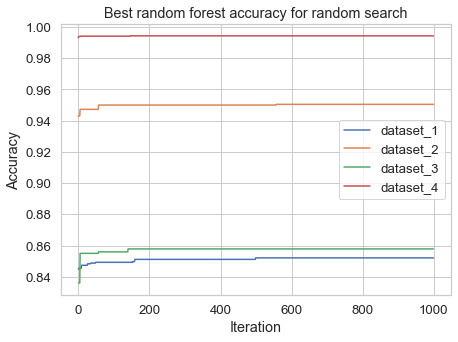

In [8]:
plot_best_accuracy(score_df_rf_rs, "random forest", "random search")
# plt.ylim(0.83, 1.01)
# plt.axvline(300, ls="--", lw=1, c="red")
# plt.savefig("rf_rs_acc.png", dpi=200, bbox_inches="tight")

### Obliczanie Thet

In [9]:
# to jest theta(j)*
print("Dla zbioru pierwszego najlepsze parametry")
print(score_df_rf_rs["ds1"].idxmax())
print("Dla zbioru drugiego najlepsze parametry")
print(score_df_rf_rs["ds2"].idxmax())
print("Dla zbioru trzeciego najlepsze parametry")
print(score_df_rf_rs["ds3"].idxmax())
print("Dla zbioru czwartego najlepsze parametry")
print(score_df_rf_rs["ds4"].idxmax())

Dla zbioru pierwszego najlepsze parametry
{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 109}
Dla zbioru drugiego najlepsze parametry
{'criterion': 'entropy', 'max_depth': 42, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 169}
Dla zbioru trzeciego najlepsze parametry
{'criterion': 'log_loss', 'max_depth': 11, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 92}
Dla zbioru czwartego najlepsze parametry
{'criterion': 'log_loss', 'max_depth': 33, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 34, 'n_estimators': 50}


In [10]:
# tu jest obliczana theta*
print("Najlepsze parametry ogólnie")
theta_star = score_df_rf_rs.mean(axis=1).idxmax()
print(theta_star)

Najlepsze parametry ogólnie
{'criterion': 'log_loss', 'max_depth': 11, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 92}


### Teraz obliczamy tunowalność algorytmu

In [11]:
# najpierw dla każdego zbioru trzeba znaleźć accuracy dla theta*
theta_star_accuracy = score_df_rf_rs.loc[score_df_rf_rs.index == theta_star].reset_index(drop=True).iloc[0]
theta_star_accuracy

ds1    0.846854
ds2    0.944643
ds3    0.857820
ds4    0.994118
Name: 0, dtype: float64

In [12]:
# dla każdego zbioru trzeba też znaleźć najlepsze accuracy
best_accuracy = score_df_rf_rs.max(axis=0)
best_accuracy

ds1    0.852070
ds2    0.950441
ds3    0.857820
ds4    0.994314
dtype: float64

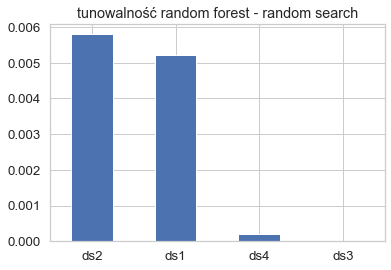

In [13]:
# teraz obliczamy tunowalność algorytmu dla każdego zbioru danych
tunability_rf_rs = best_accuracy - theta_star_accuracy
tunability_rf_rs = tunability_rf_rs.sort_values(ascending=False)
tunability_rf_rs.plot.bar(x='dataset', y='tunability', rot=0, title="tunowalność random forest - random search");

## optymalizacja hiperparametrów metodą bayesowską.

In [14]:
# score_df_rf_bm = get_bayes_method_score_df(random_forest_estimator, space_rf)
# score_df_rf_bm.to_parquet("../Wyniki/random_forest__bayes_method.parquet")
score_df_rf_bm = pd.read_parquet("../Wyniki/random_forest__bayes_method.parquet")

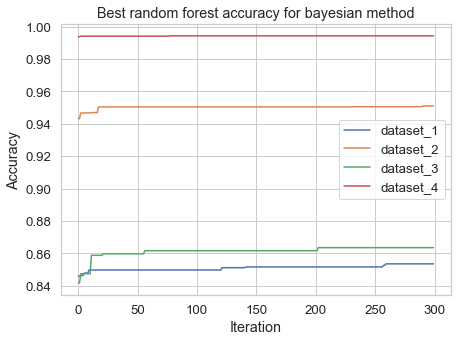

In [15]:
# wykres najlepszego accuracy
plot_best_accuracy(score_df_rf_bm, "random forest", "bayesian method")
# plt.ylim(0.83, 1.01)
# plt.savefig("rf_bs_acc.png", dpi=200, bbox_inches="tight")

Dla zbioru pierwszego najlepsze parametry
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 68}
Dla zbioru drugiego najlepsze parametry
{'criterion': 'entropy', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 9, 'n_estimators': 300}
Dla zbioru trzeciego najlepsze parametry
{'criterion': 'entropy', 'max_depth': 37, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 20, 'n_estimators': 300}
Dla zbioru czwartego najlepsze parametry
{'criterion': 'log_loss', 'max_depth': 49, 'max_features': 'sqrt', 'min_samples_leaf': 14, 'min_samples_split': 3, 'n_estimators': 99}

Najlepsze parametry ogólnie
{'criterion': 'entropy', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 9, 'n_estimators': 300}

theta*
ds1    0.852066
ds2    0.950075
ds3    0.854028
ds4    0.994118
Name: 0, dtype: float64

best accuracy
ds1    0.853494
ds2    0.9

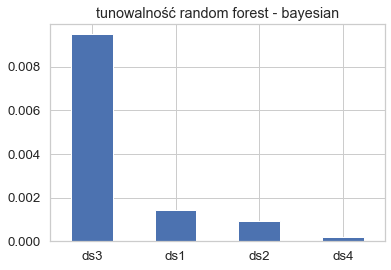

In [16]:
# obliczanie tunowalności
## to jest theta(j)*
print("Dla zbioru pierwszego najlepsze parametry")
print(score_df_rf_bm["ds1"].idxmax())
print("Dla zbioru drugiego najlepsze parametry")
print(score_df_rf_bm["ds2"].idxmax())
print("Dla zbioru trzeciego najlepsze parametry")
print(score_df_rf_bm["ds3"].idxmax())
print("Dla zbioru czwartego najlepsze parametry")
print(score_df_rf_bm["ds4"].idxmax())
print()

## tu jest obliczana theta*
print("Najlepsze parametry ogólnie")
theta_star = score_df_rf_bm.mean(axis=1).idxmax()
print(theta_star)
print()

## najpierw dla każdego zbioru trzeba znaleźć accuracy dla theta*
theta_star_accuracy = score_df_rf_bm.loc[score_df_rf_bm.index == theta_star].reset_index(drop=True).iloc[0]
print("theta*")
print(theta_star_accuracy)
print()

## dla każdego zbioru trzeba też znaleźć najlepsze accuracy
best_accuracy = score_df_rf_bm.max(axis=0)
print("best accuracy")
print(best_accuracy)

## teraz obliczamy tunowalność algorytmu dla każdego zbioru danych
tunability_rf_bm = best_accuracy - theta_star_accuracy
tunability_rf_bm = tunability_rf_bm.sort_values(ascending=False)
tunability_rf_bm.plot.bar(x='dataset', y='tunability', rot=0, title="tunowalność random forest - bayesian");

# KNN

## random search

In [17]:
# score_df_knn_rs = get_random_search_score_df(knn_estimator, space_knn)
# score_df_knn_rs.to_parquet("../Wyniki/knn__random_search2.parquet")
score_df_knn_rs = pd.read_parquet("../Wyniki/knn__random_search.parquet")
score_df_knn_rs.head(5)

,ds1,ds2,ds3,ds4
params,,,,
"{'n_neighbors': 13, 'p': 0.6464405117819745, 'weights': 'distance'}",0.832159,0.945009,0.839810,0.992157
"{'n_neighbors': 16, 'p': 1.1455680991172588, 'weights': 'distance'}",0.831689,0.943941,0.824645,0.991765
"{'n_neighbors': 22, 'p': 0.808290128214932, 'weights': 'distance'}",0.836902,0.944643,0.831280,0.991569
"{'n_neighbors': 1, 'p': 0.6346495489906909, 'weights': 'distance'}",0.707455,0.927340,0.785782,0.992353
"{'n_neighbors': 4, 'p': 0.27096439801671424, 'weights': 'uniform'}",0.814136,0.943391,0.842654,0.992549


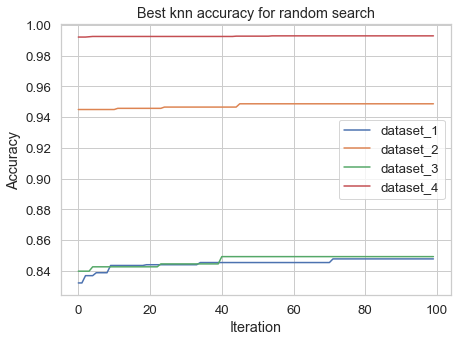

In [18]:
# wykres najlepszego accuracy
plot_best_accuracy(score_df_knn_rs, "knn", "random search")
# plt.ylim(0.79, 1.01)
# plt.savefig("knn_rs_acc.png", dpi=200, bbox_inches="tight")

Dla zbioru pierwszego najlepsze parametry
{'n_neighbors': 29, 'p': 1.927361858241558, 'weights': 'uniform'}
Dla zbioru drugiego najlepsze parametry
{'n_neighbors': 5, 'p': 0.10617551198289243, 'weights': 'uniform'}
Dla zbioru trzeciego najlepsze parametry
{'n_neighbors': 10, 'p': 0.31580454038696115, 'weights': 'uniform'}
Dla zbioru czwartego najlepsze parametry
{'n_neighbors': 4, 'p': 1.0774163581100598, 'weights': 'distance'}

Najlepsze parametry ogólnie
{'n_neighbors': 10, 'p': 0.31580454038696115, 'weights': 'uniform'}

theta*
ds1    0.840687
ds2    0.945436
ds3    0.849289
ds4    0.991961
Name: 0, dtype: float64

best accuracy
ds1    0.847803
ds2    0.948732
ds3    0.849289
ds4    0.992941
dtype: float64


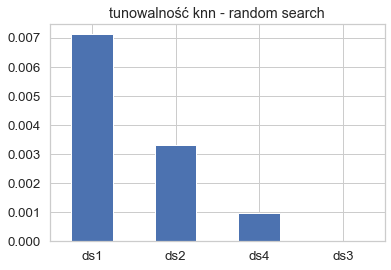

In [19]:
# obliczanie tunowalności
## to jest theta(j)*
print("Dla zbioru pierwszego najlepsze parametry")
print(score_df_knn_rs["ds1"].idxmax())
print("Dla zbioru drugiego najlepsze parametry")
print(score_df_knn_rs["ds2"].idxmax())
print("Dla zbioru trzeciego najlepsze parametry")
print(score_df_knn_rs["ds3"].idxmax())
print("Dla zbioru czwartego najlepsze parametry")
print(score_df_knn_rs["ds4"].idxmax())
print()

## tu jest obliczana theta*
print("Najlepsze parametry ogólnie")
theta_star = score_df_knn_rs.mean(axis=1).idxmax()
print(theta_star)
print()

## najpierw dla każdego zbioru trzeba znaleźć accuracy dla theta*
theta_star_accuracy = score_df_knn_rs.loc[score_df_knn_rs.index == theta_star].reset_index(drop=True).iloc[0]
print("theta*")
print(theta_star_accuracy)
print()

## dla każdego zbioru trzeba też znaleźć najlepsze accuracy
best_accuracy = score_df_knn_rs.max(axis=0)
print("best accuracy")
print(best_accuracy)

## teraz obliczamy tunowalność algorytmu dla każdego zbioru danych
tunability_knn_rs = best_accuracy - theta_star_accuracy
tunability_knn_rs = tunability_knn_rs.sort_values(ascending=False)
tunability_knn_rs.plot.bar(x='dataset', y='tunability', rot=0, title="tunowalność knn - random search");


## optymalizacja hiperparametrów metodą bayesowską.



In [20]:
# score_df_knn_bm = get_bayes_method_score_df(knn_estimator, space_knn)
# score_df_knn_bm.to_parquet("../Wyniki/knn__bayes_method.parquet")
score_df_knn_bm = pd.read_parquet("../Wyniki/knn__bayes_method.parquet")

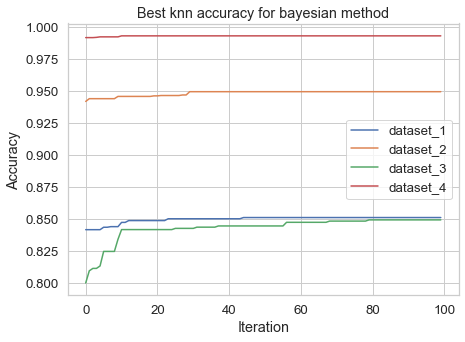

In [21]:
# wykres najlepszego accuracy
plot_best_accuracy(score_df_knn_bm, "knn", "bayesian method")
# plt.ylim(0.79, 1.01)
# plt.savefig("knn_bs_acc.png", dpi=200, bbox_inches="tight")

Dla zbioru pierwszego najlepsze parametry
{'n_neighbors': 18, 'p': 0.001, 'weights': 'uniform'}
Dla zbioru drugiego najlepsze parametry
{'n_neighbors': 19, 'p': 0.001, 'weights': 'uniform'}
Dla zbioru trzeciego najlepsze parametry
{'n_neighbors': 17, 'p': 1.11269838500371, 'weights': 'distance'}
Dla zbioru czwartego najlepsze parametry
{'n_neighbors': 30, 'p': 0.001, 'weights': 'uniform'}

Najlepsze parametry ogólnie
{'n_neighbors': 18, 'p': 0.001, 'weights': 'uniform'}

theta*
ds1    0.851123
ds2    0.943361
ds3    0.781991
ds4    0.991569
Name: 0, dtype: float64

best accuracy
ds1    0.851123
ds2    0.949495
ds3    0.849289
ds4    0.993137
dtype: float64


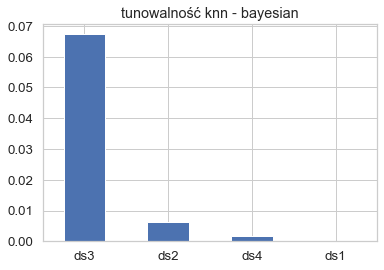

In [22]:
# obliczanie tunowalności
## to jest theta(j)*
print("Dla zbioru pierwszego najlepsze parametry")
print(score_df_knn_bm["ds1"].idxmax())
print("Dla zbioru drugiego najlepsze parametry")
print(score_df_knn_bm["ds2"].idxmax())
print("Dla zbioru trzeciego najlepsze parametry")
print(score_df_knn_bm["ds3"].idxmax())
print("Dla zbioru czwartego najlepsze parametry")
print(score_df_knn_bm["ds4"].idxmax())
print()

## tu jest obliczana theta*
print("Najlepsze parametry ogólnie")
theta_star = score_df_knn_bm.mean(axis=1).idxmax()
print(theta_star)
print()

## najpierw dla każdego zbioru trzeba znaleźć accuracy dla theta*
theta_star_accuracy = score_df_knn_bm.loc[score_df_knn_bm.index == theta_star].reset_index(drop=True).iloc[0]
print("theta*")
print(theta_star_accuracy)
print()

## dla każdego zbioru trzeba też znaleźć najlepsze accuracy
best_accuracy = score_df_knn_bm.max(axis=0)
print("best accuracy")
print(best_accuracy)

## teraz obliczamy tunowalność algorytmu dla każdego zbioru danych
tunability_knn_bm = best_accuracy - theta_star_accuracy
tunability_knn_bm = tunability_knn_bm.sort_values(ascending=False)
tunability_knn_bm.plot.bar(x='dataset', y='tunability', rot=0, title="tunowalność knn - bayesian");

# Adaboost

## random search

In [23]:
# score_df_adaboost_rs = get_random_search_score_df(adaboost_estimator, space_adaboost)
# score_df_adaboost_rs.to_parquet("../Wyniki/adaboost__random_search.parquet")
score_df_adaboost_rs = pd.read_parquet("../Wyniki/adaboost__random_search.parquet")
score_df_adaboost_rs.head(5)

,ds1,ds2,ds3,ds4
params,,,,
"{'algorithm': 'SAMME', 'learning_rate': 0.1831624038184891, 'n_estimators': 222}",0.841166,0.94211,0.822749,0.992353
"{'algorithm': 'SAMME', 'learning_rate': 0.4422544225997849, 'n_estimators': 97}",0.845907,0.94211,0.826540,0.993725
"{'algorithm': 'SAMME', 'learning_rate': 0.24376795198947124, 'n_estimators': 167}",0.842589,0.94211,0.825592,0.992941
"{'algorithm': 'SAMME', 'learning_rate': 0.17938765314486518, 'n_estimators': 242}",0.842114,0.94211,0.824645,0.992941
"{'algorithm': 'SAMME.R', 'learning_rate': 0.0943718352991398, 'n_estimators': 373}",0.848756,0.94211,0.854028,0.993137


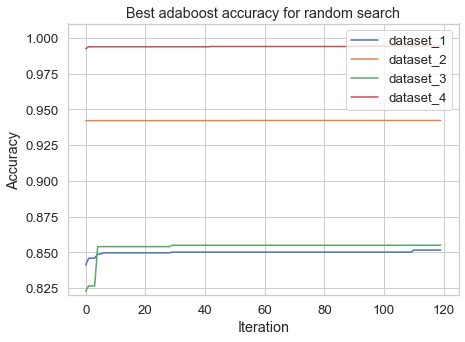

In [31]:
# wykres najlepszego accuracy
plot_best_accuracy(score_df_adaboost_rs, "adaboost", "random search")
# plt.ylim(0.82, 1.01)
# plt.savefig("ada_rs_acc.png", dpi=200, bbox_inches="tight")

Dla zbioru pierwszego najlepsze parametry
{'algorithm': 'SAMME.R', 'learning_rate': 0.10686830174353994, 'n_estimators': 423}
Dla zbioru drugiego najlepsze parametry
{'algorithm': 'SAMME', 'learning_rate': 1.8805195308138094, 'n_estimators': 252}
Dla zbioru trzeciego najlepsze parametry
{'algorithm': 'SAMME', 'learning_rate': 0.6046930025795263, 'n_estimators': 293}
Dla zbioru czwartego najlepsze parametry
{'algorithm': 'SAMME', 'learning_rate': 0.3433454556909712, 'n_estimators': 171}

Najlepsze parametry ogólnie
{'algorithm': 'SAMME.R', 'learning_rate': 0.10686830174353994, 'n_estimators': 423}

theta*
ds1    0.851600
ds2    0.942110
ds3    0.854028
ds4    0.992549
Name: 0, dtype: float64

best accuracy
ds1    0.851600
ds2    0.942201
ds3    0.854976
ds4    0.994118
dtype: float64


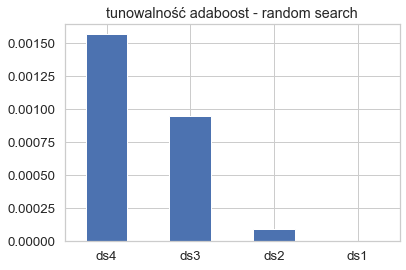

In [25]:
# obliczanie tunowalności
## to jest theta(j)*
print("Dla zbioru pierwszego najlepsze parametry")
print(score_df_adaboost_rs["ds1"].idxmax())
print("Dla zbioru drugiego najlepsze parametry")
print(score_df_adaboost_rs["ds2"].idxmax())
print("Dla zbioru trzeciego najlepsze parametry")
print(score_df_adaboost_rs["ds3"].idxmax())
print("Dla zbioru czwartego najlepsze parametry")
print(score_df_adaboost_rs["ds4"].idxmax())
print()

## tu jest obliczana theta*
print("Najlepsze parametry ogólnie")
theta_star = score_df_adaboost_rs.mean(axis=1).idxmax()
print(theta_star)
print()

## najpierw dla każdego zbioru trzeba znaleźć accuracy dla theta*
theta_star_accuracy = score_df_adaboost_rs.loc[score_df_adaboost_rs.index == theta_star].reset_index(drop=True).iloc[0]
print("theta*")
print(theta_star_accuracy)
print()

## dla każdego zbioru trzeba też znaleźć najlepsze accuracy
best_accuracy = score_df_adaboost_rs.max(axis=0)
print("best accuracy")
print(best_accuracy)

## teraz obliczamy tunowalność algorytmu dla każdego zbioru danych
tunability_adaboost_rs = best_accuracy - theta_star_accuracy
tunability_adaboost_rs = tunability_adaboost_rs.sort_values(ascending=False)
tunability_adaboost_rs.plot.bar(x='dataset', y='tunability', rot=0, title="tunowalność adaboost - random search");

## optymalizacja hiperparametrów metodą bayesowską.


In [26]:
# score_df_adaboost_bm = get_bayes_method_score_df(adaboost_estimator, space_adaboost)
# score_df_adaboost_bm.to_parquet("adaboost__bayes_method.parquet")
score_df_adaboost_bm = pd.read_parquet("../Wyniki/adaboost__bayes_method.parquet")

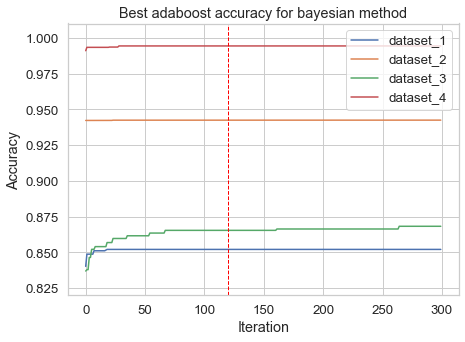

In [30]:
# wykres najlepszego accuracy
plot_best_accuracy(score_df_adaboost_bm, "adaboost", "bayesian method")
# plt.ylim(0.82, 1.01)
# plt.axvline(120, ls="--", lw=1, c="red")
# plt.savefig("ada_bs_acc.png", dpi=200, bbox_inches="tight")

Dla zbioru pierwszego najlepsze parametry
{'algorithm': 'SAMME.R', 'learning_rate': 0.09163955747116022, 'n_estimators': 500}
Dla zbioru drugiego najlepsze parametry
{'algorithm': 'SAMME.R', 'learning_rate': 1.9945465653817507, 'n_estimators': 401}
Dla zbioru trzeciego najlepsze parametry
{'algorithm': 'SAMME.R', 'learning_rate': 0.45667880344517453, 'n_estimators': 50}
Dla zbioru czwartego najlepsze parametry
{'algorithm': 'SAMME.R', 'learning_rate': 1.9864965254666576, 'n_estimators': 500}

Najlepsze parametry ogólnie
{'algorithm': 'SAMME.R', 'learning_rate': 0.45667880344517453, 'n_estimators': 50}

theta*
ds1    0.850176
ds2    0.942293
ds3    0.868246
ds4    0.992353
Name: 0, dtype: float64

best accuracy
ds1    0.852075
ds2    0.942446
ds3    0.868246
ds4    0.994314
dtype: float64


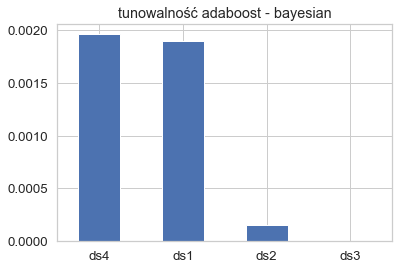

In [28]:
# obliczanie tunowalności
## to jest theta(j)*
print("Dla zbioru pierwszego najlepsze parametry")
print(score_df_adaboost_bm["ds1"].idxmax())
print("Dla zbioru drugiego najlepsze parametry")
print(score_df_adaboost_bm["ds2"].idxmax())
print("Dla zbioru trzeciego najlepsze parametry")
print(score_df_adaboost_bm["ds3"].idxmax())
print("Dla zbioru czwartego najlepsze parametry")
print(score_df_adaboost_bm["ds4"].idxmax())
print()

## tu jest obliczana theta*
print("Najlepsze parametry ogólnie")
theta_star = score_df_adaboost_bm.mean(axis=1).idxmax()
print(theta_star)
print()

## najpierw dla każdego zbioru trzeba znaleźć accuracy dla theta*
theta_star_accuracy = score_df_adaboost_bm.loc[score_df_adaboost_bm.index == theta_star].reset_index(drop=True).iloc[0]
print("theta*")
print(theta_star_accuracy)
print()

## dla każdego zbioru trzeba też znaleźć najlepsze accuracy
best_accuracy = score_df_adaboost_bm.max(axis=0)
print("best accuracy")
print(best_accuracy)

## teraz obliczamy tunowalność algorytmu dla każdego zbioru danych
tunability_adaboost_bm = best_accuracy - theta_star_accuracy
tunability_adaboost_bm = tunability_adaboost_bm.sort_values(ascending=False)
tunability_adaboost_bm.plot.bar(x='dataset', y='tunability', rot=0, title="tunowalność adaboost - bayesian");

### Wykres podsumowujący

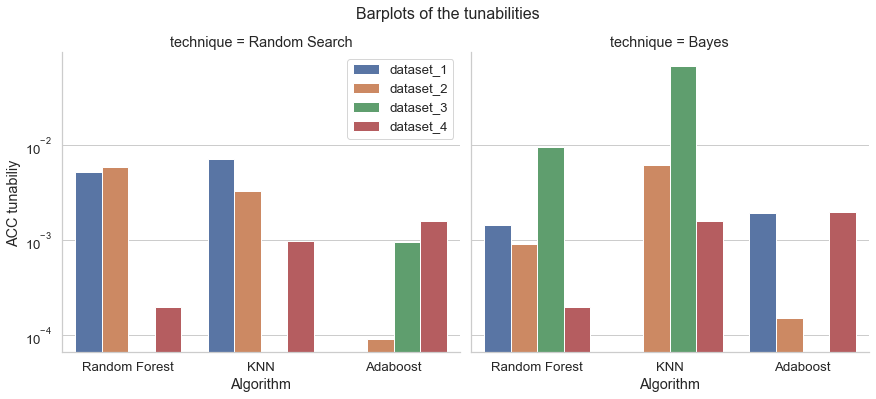

In [29]:
names_to_replace = {
    "ds1": "dataset_1",
    "ds2": "dataset_2",
    "ds3": "dataset_3",
    "ds4": "dataset_4",
}

tmp = pd.concat([
    tunability_rf_rs.to_frame(name="ACC tunabiliy").assign(Algorithm="Random Forest", technique="Random Search").reset_index(names="dataset").replace(names_to_replace),
    tunability_knn_rs.to_frame(name="ACC tunabiliy").assign(Algorithm="KNN", technique="Random Search").reset_index(names="dataset").replace(names_to_replace),
    tunability_adaboost_rs.to_frame(name="ACC tunabiliy").assign(Algorithm="Adaboost", technique="Random Search").reset_index(names="dataset").replace(names_to_replace),
    tunability_rf_bm.to_frame(name="ACC tunabiliy").assign(Algorithm="Random Forest", technique="Bayes").reset_index(names="dataset").replace(names_to_replace),
    tunability_knn_bm.to_frame(name="ACC tunabiliy").assign(Algorithm="KNN", technique="Bayes").reset_index(names="dataset").replace(names_to_replace),
    tunability_adaboost_bm.to_frame(name="ACC tunabiliy").assign(Algorithm="Adaboost", technique="Bayes").reset_index(names="dataset").replace(names_to_replace),
])
g = sns.catplot(
    data=tmp,
    x="Algorithm",
    y="ACC tunabiliy",
    hue="dataset",
    kind="bar",
    col="technique",
    hue_order=["dataset_1", "dataset_2", "dataset_3", "dataset_4"],
    legend_out=False,
    height=5,
    aspect=1.2
)
g.legend.set_title(None)
plt.suptitle("Barplots of the tunabilities", fontsize=16, y=1.05 )
plt.yscale("log")
# plt.savefig("tunabilities.png", dpi=200, bbox_inches="tight")
plt.show()